In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('videogames.csv')

In [3]:
df.columns = df.columns.str.strip()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Dropping rows with missing values for the columns that have less than 16448 values and making sure everything is consistent

In [4]:
df = df.dropna(subset = ['Genre','Year_of_Release'])
df = df.reset_index()
df = df.drop(columns = ['Name','Rating','User_Count','Developer','User_Score','Publisher','Platform'], axis = 1)
df['Critic_Score'] = df['Critic_Score'].fillna(0)
df['Critic_Count'] = df['Critic_Count'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16448 entries, 0 to 16447
Data columns (total 10 columns):
index              16448 non-null int64
Year_of_Release    16448 non-null float64
Genre              16448 non-null object
NA_Sales           16448 non-null float64
EU_Sales           16448 non-null float64
JP_Sales           16448 non-null float64
Other_Sales        16448 non-null float64
Global_Sales       16448 non-null float64
Critic_Score       16448 non-null float64
Critic_Count       16448 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


Plotting Global_Sales the target variable. Looks like it is pretty concentrated with very few really high sellers

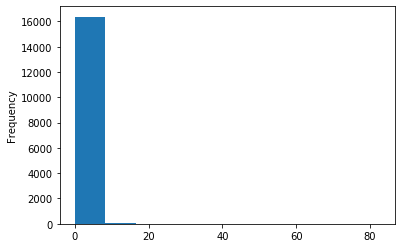

In [5]:
df.Global_Sales.plot.hist()

Using genre as my single categorical variable and keeping the one hot separate

In [6]:
one_hot = pd.get_dummies(df['Genre'])
one_hot.head()

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0


Dropping Genre, looking at different graphs

In [7]:
df = df.drop(columns = ['Genre','index'])

In [8]:
#sns.pairplot(df, height = 1.2, aspect=1.5)

Joining the one hot briefly to look at correlations between variables. Naturally North American, European, Japanese and Other Sales have a strong correlation with Global Sales

In [9]:
new_df = df.join(one_hot)

In [10]:
 new_df.corr()['Global_Sales'].sort_values(ascending=False)

Global_Sales       1.000000
NA_Sales           0.941235
EU_Sales           0.901671
Other_Sales        0.748912
JP_Sales           0.613316
Critic_Count       0.245880
Critic_Score       0.148720
Platform           0.061628
Shooter            0.050240
Role-Playing       0.018492
Racing             0.009856
Sports             0.008313
Fighting          -0.001091
Action            -0.005452
Simulation        -0.012568
Puzzle            -0.013823
Misc              -0.016800
Strategy          -0.037022
Adventure         -0.066653
Year_of_Release   -0.076340
Name: Global_Sales, dtype: float64

Creating the graph of polynomial degree vs. MSE to determine which degree to use

In [11]:
x = df.drop(['Global_Sales'], axis = 1)
y = df['Global_Sales']

[2.6866852305139686, 2.381362357894828e-28, 4.325029568017381e-25, 8.261031346087776e-14, 9.207698776967785e-13, 1.1822967024033693e-11, 6.652653096782323e-12, 4.0525300031927584e-11] [1.826808068269636, 2.3808858348297957e-28, 2.8222756869041843e-25, 1.40070113619819e-12, 1.716097022936123e-08, 3.6810021431728756e-08, 6.170352218771658e-07, 4.510068342077331e-07]


Text(0.5, 0, 'degree')

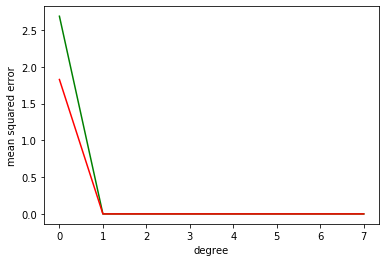

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

mindegree = 0
maxdegree = 8
train_error = []
test_error = []
for deg in range(mindegree,maxdegree):
    model = make_pipeline(PolynomialFeatures(deg),LinearRegression())
    model.fit(x_train,y_train)
    train_error.append(mean_squared_error(y_train,model.predict(x_train)))
    test_error.append(mean_squared_error(y_test,model.predict(x_test)))
print(train_error,test_error)
plt.plot(np.arange(mindegree,maxdegree), train_error, color='green', label='train')
plt.plot(np.arange(mindegree,maxdegree), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')

Using degree 2 polynomial and scaler, then joining with the one-hot

In [14]:
model = make_pipeline(PolynomialFeatures(2), StandardScaler())
model.fit(df)

pd.DataFrame(model.transform(df))
X = one_hot.join(pd.DataFrame(model.transform(df)))

Putting the scaled and joined dataframe into ridgeCV

In [17]:
model = RidgeCV(cv=10, alphas = [0.0001, 0.1, 1])
model.fit(x,y)
model.score(x,y)

print(model.score(x, y))
print(f"R^2: {model.score(x,y)}")
print(f"Adjusted R^2: {1 - (1-model.score(x,y))*(len(y)-1)/(len(y)-x.shape[1]-1)}")
print('alpha: ', model.alpha_)

print(model.intercept_)
print(model.coef_)

0.9999887852605488
R^2: 0.9999887852605488
Adjusted R^2: 0.9999887804854164
alpha:  1.0
0.011066337326831155
[-5.35433889e-06  1.00015186e+00  1.00038072e+00  9.99243451e-01
  9.96725527e-01  3.67343044e-06 -5.53451257e-06]


### Lauren

In [ ]:
### Reading in data and dealing with cleaning
df = pd.read_csv('videogames.csv')
df = df.dropna(subset = ['Genre','Year_of_Release'])
df = df.reset_index()
df = df.drop(columns = ['Name','Rating','User_Count','Developer','User_Score','Publisher','Platform'], axis = 1)
df['Critic_Score'] = df['Critic_Score'].fillna(0)
df['Critic_Count'] = df['Critic_Count'].fillna(0)


# keep categorical info separate to use later
one_hot = pd.get_dummies(df['Genre'])
y = df['Global_Sales']
df = df.drop(columns = ['Genre', 'Global_Sales', 'index'])

df.head()

In [ ]:
#  apply polynomial features and scaling to the NUMERICAL INPUT DATA ONLY
model = make_pipeline(PolynomialFeatures(2), StandardScaler())
model.fit(df)

pd.DataFrame(model.transform(df))

In [ ]:
# merge the categorical info and numerical scaled info back together
X = one_hot.join(pd.DataFrame(model.transform(df)))
#apply the ridge regression
model = RidgeCV(cv=10, alphas = [0.0001, 0.1, 1])
model.fit(X,y)
model.score(X,y)

In [ ]:
### MAKE SURE DF CONTAINS ONLY THE NUMERICAL VARIABLES LEFT

x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

mindegree = 0
maxdegree = 6
train_error = []
test_error = []
for deg in range(mindegree,maxdegree):
    model = make_pipeline(PolynomialFeatures(deg),LinearRegression())
    model.fit(x_train,y_train)
    train_error.append(mean_squared_error(y_train,model.predict(x_train)))
    test_error.append(mean_squared_error(y_test,model.predict(x_test)))
print(train_error,test_error)
plt.plot(np.arange(mindegree,maxdegree), train_error, color='green', label='train')
plt.plot(np.arange(mindegree,maxdegree), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')